# Project Objective
Use bioinformatics tools to identify potential drugs for the treatment of anthrax.

# Acquire

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from numpy.random import seed
seed(1)

from numpy.random import randn

from scipy.stats import mannwhitneyu

# pip install chembl_webresource_client
from chembl_webresource_client.new_client import new_client

# conda install -c conda-forge rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [2]:
# Target search for coronavirus on ChEMBL
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [3]:
# Focusing on 'Replicase polyprotein 1ab' on index row 6
selected_target = targets.target_chembl_id[4]

# Outputs the unique id of the target from ChEMBL
selected_target

'CHEMBL3927'

In [4]:
# Get bioactivity data for our target coronavirus protein
activity = new_client.activity

# The standard_type='IC50' filters for bioactivity tests using the IC50 standard of measuring
res = activity.filter(target_chembl_id = selected_target).filter(standard_type='IC50')

In [5]:
df = pd.DataFrame.from_dict(res)
df.head()

# standard_value column represents potency
# a smaller number means a smaller dose is needed to exhibit and effect
# lower value means more potent, higher value means less potent

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0


In [6]:
df.to_csv('bioactivity_data.csv', index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   activity_comment           0 non-null      object
 1   activity_id                133 non-null    int64 
 2   activity_properties        133 non-null    object
 3   assay_chembl_id            133 non-null    object
 4   assay_description          133 non-null    object
 5   assay_type                 133 non-null    object
 6   assay_variant_accession    0 non-null      object
 7   assay_variant_mutation     0 non-null      object
 8   bao_endpoint               133 non-null    object
 9   bao_format                 133 non-null    object
 10  bao_label                  133 non-null    object
 11  canonical_smiles           133 non-null    object
 12  data_validity_comment      42 non-null     object
 13  data_validity_description  42 non-null     object
 14  document_c

In [8]:
# look for null values
#df[df.value.notna()]
df.value.isna().sum()

0

# Prepare

In [9]:
# Divide the compounds into classes of potency
bioactivity_class = []
for i in df.standard_value:
    if float(i) >= 10000:
        bioactivity_class.append('inactive')
    elif float(i) <= 1000:
        bioactivity_class.append('active')
    else:
        bioactivity_class.append('intermediate')

bioactivity_class

['intermediate',
 'intermediate',
 'inactive',
 'inactive',
 'intermediate',
 'active',
 'intermediate',
 'active',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'active',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'intermediate',
 'inactive',
 'inactive',
 'intermediate',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inactive',
 'inact

In [10]:
# this is a list of the moleculues tested against our target
df.molecule_chembl_id

0       CHEMBL187579
1       CHEMBL188487
2       CHEMBL185698
3       CHEMBL426082
4       CHEMBL187717
           ...      
128    CHEMBL2146517
129     CHEMBL187460
130     CHEMBL363535
131     CHEMBL227075
132      CHEMBL45830
Name: molecule_chembl_id, Length: 133, dtype: object

In [11]:
# bioactivity_class has the same length as df.molecule_chembl_id
len(bioactivity_class)

133

In [12]:
# Iterate the molecule_chembl_id to a list
#mol_cid = []
#for i in df.molecule_chembl_id:
#    mol_cid.append(i)

# Iterate canonical_smiles to a list
#canonical_smiles = []
#for i in df.canonical_smiles:
#    canonical_smiles.append(i)

# Iterate standard_value to a list
#standard_value = []
#for i in df.standard_value:
#    standard_value.append(i)

# Alternative method to create the lists
#mol_cid = df.molecule_chembl_id.to_list()
#canonical_smiles = df.canonical_smiles.to_list()
#standard_value = df.standard_value.to_list()

In [17]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
bioactivity_df = df[selection]

# this method gives a warning (not an error)
# chem_df['bioactivity_class'] = bioactivity_class

# alternative method to add bioactivity_class column to dataframe
bioactivity_df = pd.concat([bioactivity_df, pd.Series(bioactivity_class)], axis=1 )
bioactivity_df = bioactivity_df.rename(columns={0:'bioactivity_class'})

bioactivity_df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


In [18]:
# Every single compound is an active agent
bioactivity_df.bioactivity_class.value_counts()

inactive        104
active           15
intermediate     14
Name: bioactivity_class, dtype: int64

In [19]:
# saved file of bioactivity dataframe
bioactivity_df.to_csv('bioactivity_preprocessed_data.csv', index=False)

# Explore

In [20]:
# calculate lipinski descriptors (describe druglikeness)
# smiles is a chemical notation that describes a compounds chemical structure
# this function gives the four parameters described by Lipinski's rule of five
def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)
        
    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        
        row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])
        
        if(i==0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        
        i = i + 1
        
    columnNames = ['MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)
    
    return descriptors

In [21]:
# this dataframe holds the four parameters described by Lipinski's rule of five
# these chemical parameters can be used to estimate the druglikeness of a compound
# this df has the same number of rows as bioactivity_df
lipinski_df = lipinski(bioactivity_df.canonical_smiles)
lipinski_df

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [22]:
combined_df = pd.concat([bioactivity_df, lipinski_df], axis=1)
combined_df.standard_value = combined_df.standard_value.astype('float64')
combined_df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


In [23]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  133 non-null    object 
 1   canonical_smiles    133 non-null    object 
 2   standard_value      133 non-null    float64
 3   bioactivity_class   133 non-null    object 
 4   MW                  133 non-null    float64
 5   LogP                133 non-null    float64
 6   NumHDonors          133 non-null    float64
 7   NumHAcceptors       133 non-null    float64
dtypes: float64(5), object(3)
memory usage: 8.4+ KB


In [24]:
# convert IC50 to pIC50
# this is done because IC50 has an uneven distribution
# taking the negative log makes the distribution more even

def pIC50(input):
    pIC50 = []
    
    for i in input['standard_value_norm']:
        molar = i * (10**-9) # converts nanomolar to molar
        pIC50.append(-np.log10(molar))
        
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
    
    return x

In [25]:
# standard_value >100,000,000 will give negative values after negative logarithm
# thus, we need to check if values are >100,000,000
combined_df.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

In [26]:
# our standard_value is too large, therefore we will cap it at 100,000,000
# getting nevative values from the negative log will make interpretation more difficult

# function to cap values at 100,000,000
def norm_value(input):
    norm = []
    
    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)
    
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
    
    return x    

In [27]:
norm_df = norm_value(combined_df)
norm_df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [28]:
# after capping, our standard_values are <= 100,000,000
norm_df.standard_value_norm.describe()

count    1.330000e+02
mean     2.110164e+07
std      4.089714e+07
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [29]:
final_df = pIC50(norm_df)
final_df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [30]:
final_df.pIC50.describe()

count    133.000000
mean       4.060148
std        1.783762
min        1.000000
25%        3.522879
50%        4.628932
75%        4.970616
max        7.301030
Name: pIC50, dtype: float64

In [31]:
# remove the intermediate bioactivity class
final_df = final_df[final_df.bioactivity_class != 'intermediate']
final_df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


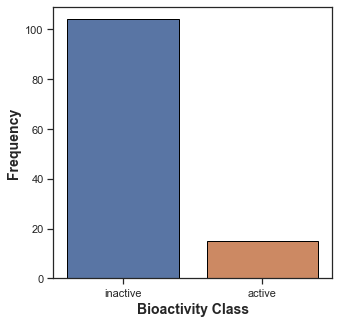

In [32]:
# frequency plot of bioactivity classes
plt.figure(figsize=(5, 5))
sns.countplot(x='bioactivity_class', data=final_df, edgecolor='black')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
#plt.savefig('plot_bioactivity_class.pdf')
plt.show()

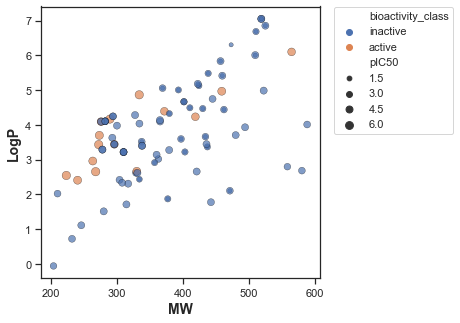

In [33]:
# the two bioactivity classes are spanning similar chemical spaces as shown in the plot below

# scatter plot of MW vs LogP
plt.figure(figsize=(5, 5))
sns.scatterplot(x='MW', y='LogP', data=final_df, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) # this creates a legend and places it outside of plot
#plt.savefig('plot_MW_vs_LogP.pdf')
plt.show()

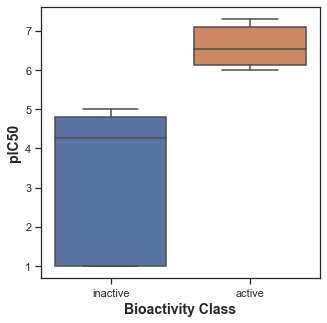

In [34]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='bioactivity_class', y='pIC50', data=final_df)
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')
#plt.savefig('plot_pIC50.pdf')
plt.show()

In [ ]:
def mannwhitney(descriptor, verbose=False):
    # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    
    # set the active and inactive
    selection = [descriptor, 'bioactivity_class']
    df = final_df[selection]
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]
    
    selection = [descriptor, 'bioactivity_class']
    df = final_df[selection]
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]
    
    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' %(stat, p))
    
    # interpret
    alpha = 0.05